# 1. Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
df = tfds.load('fashion_mnist', split = 'train')

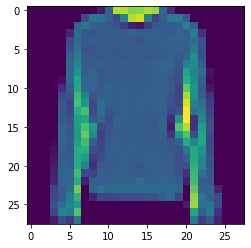

In [5]:
plt.imshow(df.as_numpy_iterator().next()['image'])

# 2. Viz Data and Build Dataset

In [7]:
dataiterator = df.as_numpy_iterator()

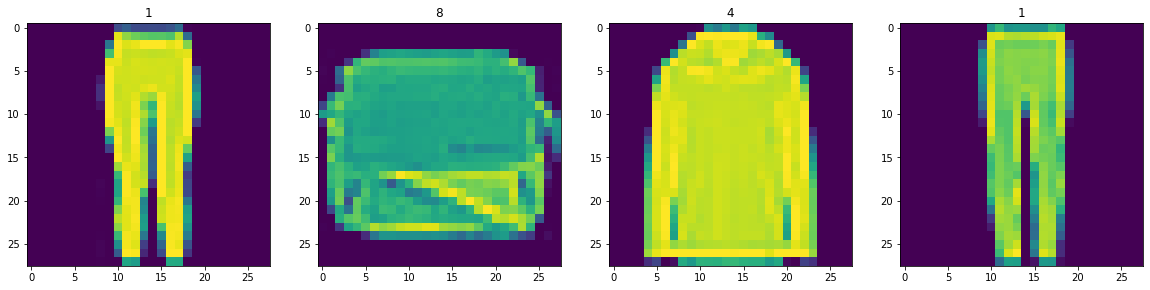

In [9]:
i = 4
fig, ax = plt.subplots( ncols = i, figsize = (20,20))
for idx in range(i):
    batch = dataiterator.next()
    ax[idx].imshow((batch['image']))
    ax[idx].title.set_text(batch['label'])

In [10]:
def scale_image(data):
    image = data['image']
    return image/255

In [11]:
df = tfds.load('fashion_mnist', split = 'train')
# running the dataset throug the scale function
df = df.map(scale_image)
# Cache tha dataset for that batch
df = df.cache()
# Shuffle it up
df = df.shuffle(60000)
# Set batch size
df = df.batch(128)
# reduces the likelihoof of  bottlenecking
df = df.prefetch(64)

In [12]:
df.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# 3. Build NN

## 3.1 Import modelling components

## 3.2 Build Generator

In [14]:
def build_generator(): 
    model = Sequential()
    
    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim = 128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    # Upsampling block 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

In [51]:
generator = build_generator()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6272)              809088    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 128)       409728    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 28, 28, 128)      

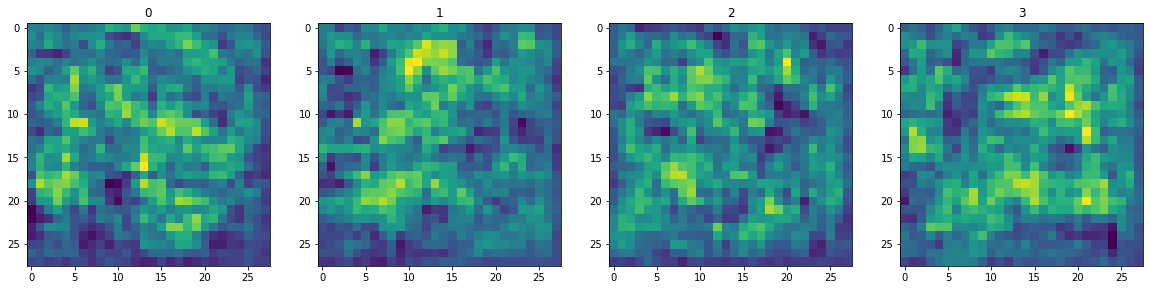

In [17]:
#predict 4 random images and show them
img = generator.predict(np.random.randn(4,128))
i = 4
fig, ax = plt.subplots( ncols = i, figsize = (20,20))
for idx in range(i):
    batch = dataiterator.next()
    ax[idx].imshow(img[idx])
    ax[idx].title.set_text(str(idx))

## 3.3 Build Discriminator

In [18]:
def build_discriminator():
    
    model = Sequential()


    model.add(Conv2D(32,5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(64,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))


    model.add(Conv2D(128,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(256,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1,activation = 'sigmoid'))

    return model


In [52]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 20, 20, 64)        51264     
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 20, 20, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 128)      

In [20]:
discriminator.predict(img)

array([[0.50162643],
       [0.5016693 ],
       [0.5015324 ],
       [0.50163126]], dtype=float32)

# 4. Training loop

In [82]:
class FashionGAN(Model):

    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.generator = generator
        self.discriminator = discriminator


    def compile(self, gen_opt, disc_opt, gen_loss, disc_loss, *args, **kwargs):
        super().compile(*args, **kwargs)
        self.gen_opt = gen_opt
        self.disc_opt = disc_opt
        self.gen_loss = gen_loss
        self.disc_loss = disc_loss

    def train_step(self, batch):
        real_images = batch
        fake_images = self.generator(tf.random.normal((128,128)), training = False)
        #train discriminator
        with tf.GradientTape() as d_tape:
            #pass the real and fake images to the disc model
            yhat_real = self.discriminator(real_images, training = True)
            yhat_fake = self.discriminator(fake_images, training = True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis = 0)

        
        
            #create labels for real and fake images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis = 0)
            #add some noise to rhe outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake = tf.concat([noise_real, noise_fake], axis = 0)
            #calculate loss

            total_d_loss = self.disc_loss(y_realfake, yhat_realfake)

        # apply backprop 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.disc_opt.apply_gradients(zip(dgrad,self.discriminator.trainable_variables))

        #Train generator
        with tf.GradientTape() as g_tape:
            
            #Generate new images
            gen_images = self.generator(tf.random.normal((128,128)), training = True)
            
            #Create the predicted lables
            predicted_labels = self.discriminator(gen_images, training = False)
            
            #claculate loss - trick to reaining to fake out the discriminator
            total_g_loss = self.gen_loss(tf.zeros_like(predicted_labels), predicted_labels)

        #apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.gen_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {'d_loss':total_d_loss, 'g_loss':total_g_loss}


        

# 4.3 Build callback and train

In [72]:
class ModelMonitor(Callback):

    def __init__(self, num_img = 3, latent_dim = 128):

        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs = None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images',f'generated_img_{epoch} _{i}.png'))

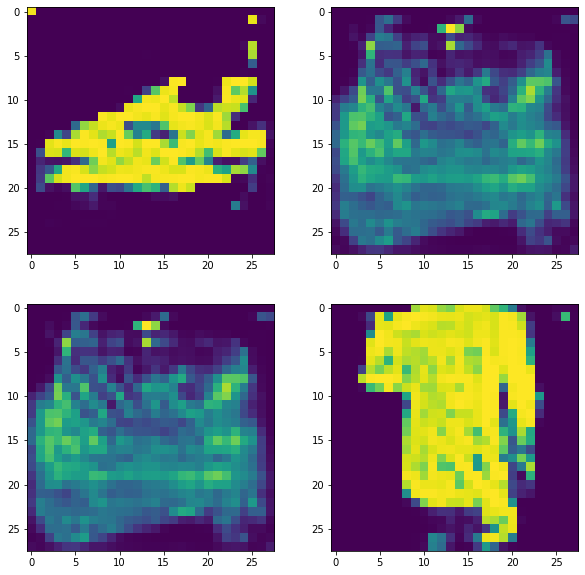

In [92]:
TRAIN  = False

if TRAIN:
    gen_opt = Adam(0.0001)
    disc_opt = Adam(0.00001)
    gen_loss = BinaryCrossentropy()
    disc_loss = BinaryCrossentropy()

    fashgan = FashionGAN(generator, discriminator)
    fashgan.compile( gen_opt, disc_opt, gen_loss, disc_loss)
    hist = fashgan.fit(df, epochs = 50, callbacks= [ModelMonitor()])
else:
    generator.load_weights('80epochs')
    imgs = generator.predict(tf.random.normal((4, 128)))
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
    for r in range(2): 
        for c in range(2): 
            ax[r][c].imshow(imgs[(r+1)*(c+1)-1])